# Neural network "playground"

## imports

In [1]:
import numpy as np
from cStringIO import StringIO
import matplotlib.pyplot as plt
import caffe
from IPython.display import clear_output, Image, display
import cv2
import PIL.Image
import os

In [2]:
os.chdir("start_deep/")

## Caffe computation mode

### CPU

In [3]:
caffe.set_mode_cpu()

### GPU

Make sure you enabled GPU support, and have a compatible (ie. nvidia) GPU

In [17]:
caffe.set_device(0)
caffe.set_mode_gpu()

## Network loading and tests

In [4]:
net = caffe.Net('deploy.prototxt', "facenet_iter_200000.caffemodel", caffe.TEST)
#training = caffe.Net('facenet_train_test.prototxt', "facenet_iter_200000.caffemodel", caffe.TRAIN)
#solver = caffe.SGDSolver('facenet_solver.prototxt')
#test_net = solver.testnets[0]

In [5]:

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

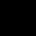

36
36
[[ 0.20703125  0.30078125  0.3046875  ...,  0.3359375   0.78125     0.9609375 ]
 [ 0.21875     0.34765625  0.36328125 ...,  0.3671875   0.7734375   0.96875   ]
 [ 0.24609375  0.41015625  0.44140625 ...,  0.3515625   0.703125    0.9609375 ]
 ..., 
 [ 0.22265625  0.3515625   0.640625   ...,  0.296875    0.4765625
   0.61328125]
 [ 0.24609375  0.3671875   0.65234375 ...,  0.1953125   0.22265625
   0.2109375 ]
 [ 0.26171875  0.37109375  0.640625   ...,  0.2421875   0.2421875
   0.23046875]]
{'prob': array([[ 0.01360568,  0.98639435]], dtype=float32)}


In [6]:
#im = np.array(PIL.Image.open('train_images/0/137021_102_88_72_72.pgm'))/256.0
im = np.array(PIL.Image.open('train_images/1/image000619.pgm'))/256.0
im_input = im[np.newaxis, np.newaxis, :, :]
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im
showarray(im)
print (len(im))
print (len(im[0]))
print (im)
output = net.forward()
print(output)
if output['prob'][0][0] >0.9:
    print "visage"

The cell bellows checks that opencv and its python bindings are properly installed

In [7]:
print cv2.__version__

2.4.13


## Face detection in image

This block performs the actual processing of an image (specified in the code btw), and checks for faces in it


starting processing
(919, 440)
(706, 338)
(543, 260)
(417, 200)
(320, 153)
(246, 117)
(189, 90)
(145, 69)
adding overlay


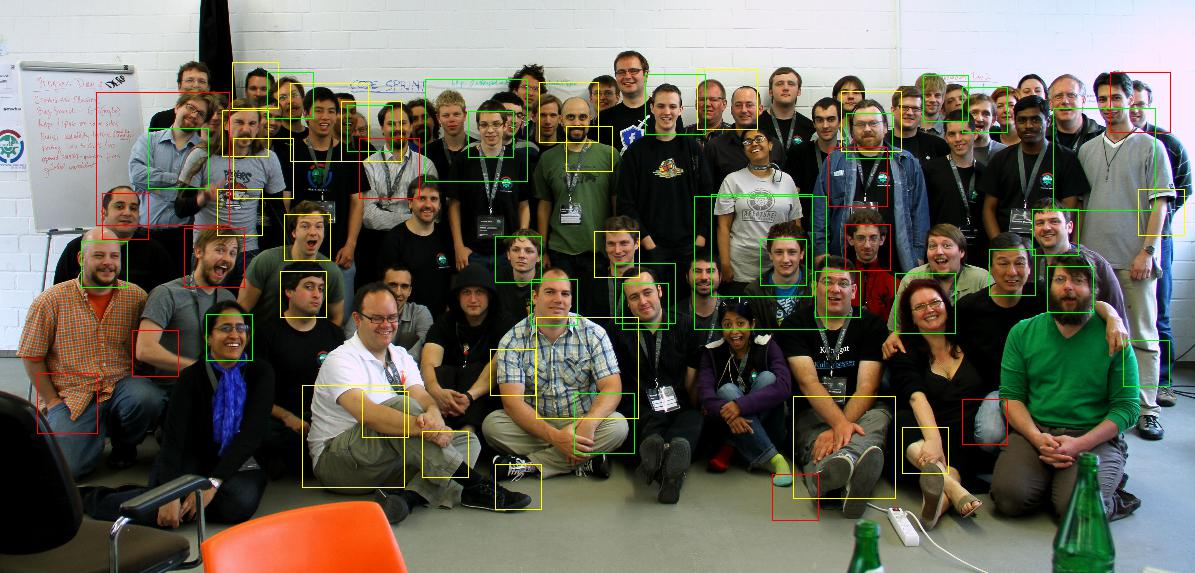

In [18]:
orig_scale = 4

def process_chunk(chunk):
    im_input = chunk[np.newaxis, np.newaxis, :, :]
    net.blobs['data'].reshape(*im_input.shape)
    net.blobs['data'].data[...] = imtmp
    return net.forward()['prob'][0][1]

def get_face_prob(chunk):
    return process_chunk(chunk)

def add_outline(img, i, j, scale, confidence):
    color = (255,255,255)
    if confidence > 0.985:
        color = (0,255,0)
    elif confidence >0.96:
        color = (255,255,0)
    else:
        color  =(255,0,0)
    for x in range (int(i*scale), int((i+36)*scale)):
        img[x][int(j*scale)]=color
        img[x][int((j+36)*scale-1)]=color
    for y in range(int(j*scale), int((j+36)*scale)):
        img[int(i*scale)][y]=color
        img[int((i+36)*scale-1)][y]=color
    return img

img =  PIL.Image.open('test_vis4.jpg')
w, h = img.size
img = img.resize((int(w/orig_scale),int(h/orig_scale)), PIL.Image.NEAREST)
imbase = img
img = img.convert('L')
w, h = img.size
scale = 1
print "starting processing"
found_pairs = []
next_scale = 1.3
next_i = 4
while w >=36*2 and h >36*2:
    img = img.resize((int(w/next_scale),int(h/next_scale)), PIL.Image.NEAREST)
    w, h = img.size
    print img.size
    im = np.array(img)
    scale*=next_scale
    
    i = 0
    j = 0
    last_result = 0
    while i < int(h-36):
        next_i = 4
        while j < int(w-36):
            imtmp = np.array(im [i:i+36, j:j+36]/256.0)
            face_prob = get_face_prob(imtmp)
            if  face_prob > 0.5:
                next_i = 2
                while j < int(w-36) and face_prob > last_result:
                    imtmp = np.array(im [i:i+36, j:j+36]/256.0)
                    last_result = face_prob
                    face_prob = get_face_prob(imtmp)
                    j += 1
                if last_result > 0.92:
                    next_i = 1
                    matched = False
                    """print last_result
                    print "visage trouvé @ %i , %i"%(i, j)
                    showarray(imtmp*255)"""
                    for pair in found_pairs[:]: # copy the list to remove while working in it
                        if (abs(pair[0]*pair[3] - i*scale) + abs(pair[1]*pair[3] - j*scale)) < 20*scale :
                            matched = True
                            if pair[2] < last_result:
                                found_pairs.remove(pair)
                                found_pairs.append((i, j, last_result, scale))
                    if not matched:
                        found_pairs.append((i, j, last_result, scale))
                    j+=36
                last_result = 0
                
            j+= 4
        i+=next_i
        j = 0
print "adding overlay"
for pair in found_pairs:
    imbase = add_outline(np.array(imbase),pair[0],pair[1],pair[3], pair[2])
showarray(imbase)

### Redraw

Allows you to define a new threshold (provided it's more aggressive than the original), without calculating everything. 

adding overlay


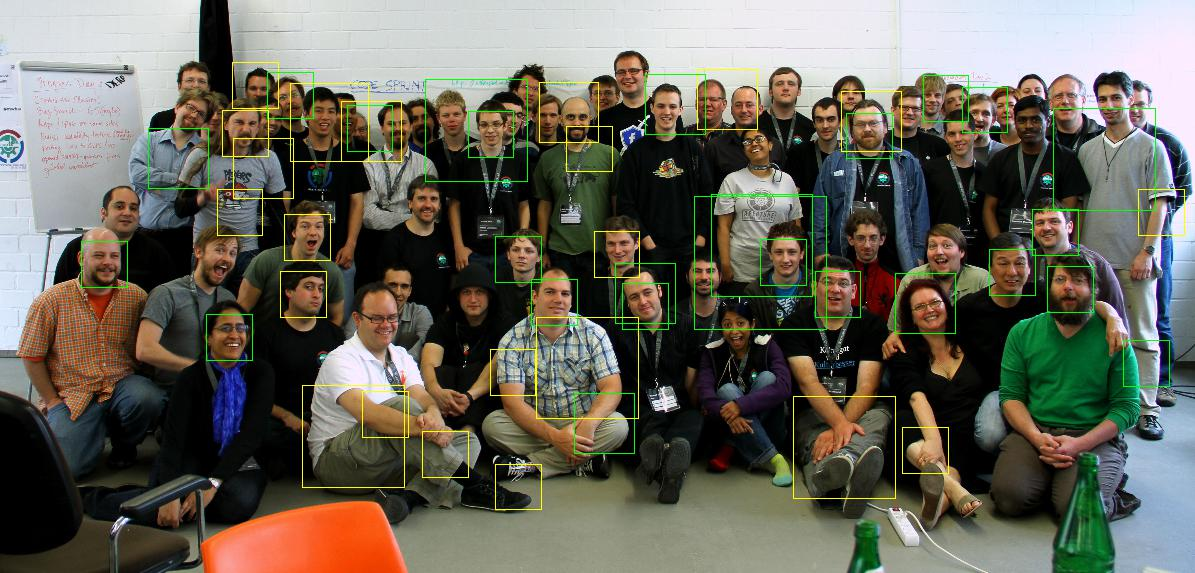

In [16]:
threshold = 0.96
img =  PIL.Image.open('test_vis4.jpg')
w, h = img.size
img = img.resize((int(w/orig_scale),int(h/orig_scale)), PIL.Image.NEAREST)
imbase = img
print "adding overlay"
for pair in found_pairs:
    if pair[2]>threshold:
        imbase = add_outline(np.array(imbase),pair[0],pair[1],pair[3], pair[2])
showarray(imbase)

In [48]:
img = PIL.Image.open('test_vis4.jpg').convert('LA')
arr = np.array(img)
w, h = img.size
print w

4782


In [40]:
a

3

## Train dataset appender

In [ ]:
img =  PIL.Image.open('neg1.jpg')
w, h = img.size
#img = img.resize((int(w/4),int(h/4)), PIL.Image.NEAREST)
imbase = img
img = img.convert('L')
w, h = img.size
scale = 1
width = 36
height = 36
import array
findex = 4327
with open('posneg.txt', 'a') as f:
    print "starting processing"
    while w >=36*2 and h >36*2:
        img = img.resize((int(w/1.3),int(h/1.3)), PIL.Image.NEAREST)
        w, h = img.size
        print img.size
        im = np.array(img)
        scale*=1.3
        found_pairs = []
        i = 0
        j = 0
        last_result = 0
        while i < int(h-36):
            while j < int(w-36):
                imtmp = np.array(im [i:i+36, j:j+36]/256.0)
                face_prob = get_face_prob(imtmp)
                if  face_prob > 0.9:
                    showarray(imtmp*255)
                    buff=array.array('B')
                    for k in range(0, 36):
                        for l in range(0, 36):
                            buff.append(int(imtmp[k][l]*255))
                    findex += 1 
                    # open file for writing 
                    filename = '0/lbe%i.pgm'%findex
                    try:
                        fout=open("train_images/"+filename, 'wb')
                    except IOError, er:
                        print "Cannot open file ", filename, "Exiting … \n", er
                    # define PGM Header
                    pgmHeader = 'P5' + '\n' + str(width) + '  ' + str(height) + '  ' + str(255) + '\n'
                    # write the header to the file
                    fout.write(pgmHeader)
                    # write the data to the file 
                    buff.tofile(fout)
                    # close the file
                    fout.close()
                    f.write(filename + " 0\n")
                j+=4
            i+=4
            j = 0
        print "adding overlay"
        for pair in found_pairs:
            imbase = add_outline(np.array(imbase),pair[0],pair[1],scale, pair[2])
showarray(imbase)

In [29]:
print findex

4327
